In [1]:
import gluon
import view_gluon

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as so
import gvar as gv

import utils

utils.set_mplstyle()

In [2]:
Nt = 64
mode = "VR"

renorm_mu = -58
escale = 1.7606
Tc=167

xi = 3.453
#xi = 1

In [3]:
prop = view_gluon.propagator(Nt,mode,n_samples='all',gtype="coulomb")
print(Nt,len(prop.prop_info))
q = prop.q
D = prop.D
    
# Z3 average
qz3, Dz3 = prop.Z3_average(q,D)
    
# _,_ = prop.half_cut()

prop.q = qz3
prop.D = Dz3

# Cone cut
qc, Dc = prop.cone_cut(radius=1)

# Lattice momentum correction
#qi = prop.correct_q(prop.q,qtype="improved")
qi = qc


64 50


In [4]:
q_norm = np.asarray([np.linalg.norm(qi_[1:]) for qi_ in qi])
q0_mask = qi[:,0] == 0

Calculate $z=\frac{p_0}{|p|}$

In [5]:
z = xi*qi[:,0]/(q_norm)

/tmp/ipykernel_1071481/3548083669.py:1: RuntimeWarning: divide by zero encountered in divide
  z = xi*qi[:,0]/(q_norm)
/tmp/ipykernel_1071481/3548083669.py:1: RuntimeWarning: invalid value encountered in divide
  z = xi*qi[:,0]/(q_norm)


Calculate $g(z)=(1+z^2)\frac{D(|p|,p_0)}{D(|p|,0)}$

In [6]:
D = prop.D
D0 = np.repeat(prop.D[q0_mask],len(q0_mask)/sum(q0_mask))

In [7]:
g = (1+z**2)*D/D0

Text(0, 0.5, '$g(z)$')

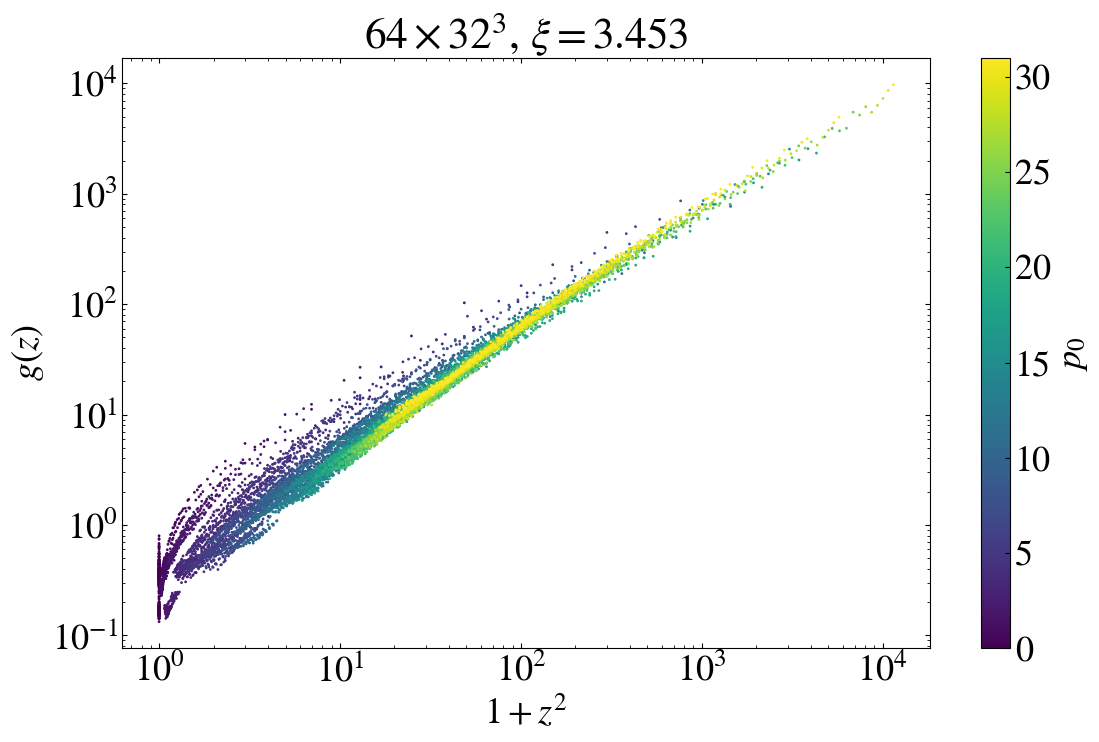

In [8]:
plt.figure(figsize=(12,8))

cbar = plt.scatter(1+z**2,[g_.mean for g_ in g],s=1,c=qi[:,0])

plt.title(f"${Nt}\\times32^3$, $\\xi={xi}$")

plt.yscale('log')
plt.xscale('log')
plt.colorbar(cbar,label="$p_0$")
plt.xlabel("$1+z^2$")
plt.ylabel("$g(z)$")

## Attempt to fit $\alpha$ dependence

-37.249760514918194 0.5370279823134861
-16.17471928129739 0.8357381330494119
-4.049130071604871 0.41872598148623236
-0.8056735379817059 0.6827902336770202
-0.9123179959707693 0.8259304450142921
-0.12065070196925375 0.6013759326716445
0.4440259742136298 0.7563046731548031
0.07299168782372065 0.7079999504215974
0.451562568607161 0.7400099613179342
0.5374416806652661 0.8220269930977093
0.4846520862285608 0.7010170159049119
0.6549944496484263 0.7678530885225457
0.5658690058369582 0.8201808756806851
0.627538278234891 0.7454204488029376
0.7339105347828161 0.8095326620689605
0.6601794053352168 0.8085848545287122
0.7290135846571891 0.8009804294501126
0.7840315092824199 0.8358526394054484
0.6927210715148587 0.765297138404807
0.7666794003462548 0.8223987828114321
0.7785530452112885 0.8560489448442383
0.7550299994663693 0.8097533611097237
0.8070553823147517 0.8467311995806507
0.7907544241242566 0.8604693528038785
0.804395541193411 0.839860191600365
0.838979001622847 0.8678062880874269
0.807857360

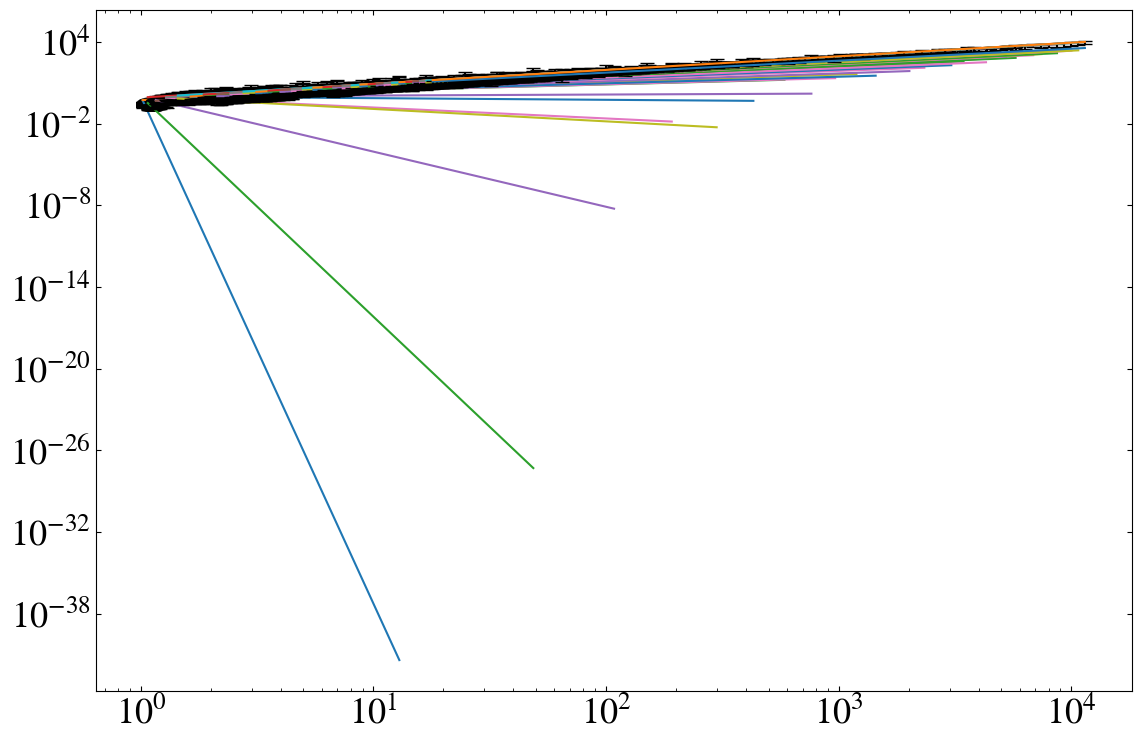

In [27]:
def alpha_fit(x,alpha):
    return x**alpha

def line_fit(x,alpha):
    return x*alpha

alphas = []
line_alphas = []

chisq = []
line_chisq=[]

cut = 1000

plt.figure(figsize=(12,8))

for q0 in np.unique(qi[:,0]):
    if q0 == 0:
        continue
    q0_mask = qi[:,0] == q0

    x = 1+z[q0_mask][1:]**2
    y = np.asarray([g_.mean for g_ in g[q0_mask][1:]])
    yerr = np.asarray([g_.sdev for g_ in g[q0_mask][1:]])
    
    plt.errorbar(x,y,yerr,c='k',ls='')
    
    popt,pcov = so.curve_fit(alpha_fit,x[x < cut], y[x < cut], sigma=yerr[x < cut],absolute_sigma=True)
    #popt,pcov = so.curve_fit(alpha_fit,x[x < cut], y[x < cut])
    popt2,pcov2 = so.curve_fit(line_fit,np.log(x[x < cut]), np.log(y[x < cut]), sigma=yerr[x < cut]/y[x < cut],absolute_sigma=True)
    
    alphas.append(gv.gvar(popt[0],np.sqrt(pcov[0][0])))
    line_alphas.append(gv.gvar(popt2[0],np.sqrt(pcov2[0][0])))
    
    print(popt[0],popt2[0])
    
    chisq.append(view_gluon.chisq([g_.mean for g_ in g[q0_mask][1:]], alpha_fit(1+z[q0_mask][1:]**2, popt[0]), [g_.sdev for g_ in g[q0_mask][1:]], ddof=sum(q0_mask)-2))
    line_chisq.append(view_gluon.chisq([g_.mean for g_ in g[q0_mask][1:]], alpha_fit(1+z[q0_mask][1:]**2, popt2[0]), [g_.sdev for g_ in g[q0_mask][1:]], ddof=sum(q0_mask)-2))
    plt.plot(x,alpha_fit(x,popt[0]))
    plt.plot(x,line_fit(x,popt2[0]))
    
plt.yscale('log')
plt.xscale('log')

In [28]:
line_chisq

[82.35676246662324,
 124.45732060835418,
 65.62278497985291,
 23.897707795478574,
 46.11177042411136,
 19.25890950397599,
 9.105528736784915,
 20.572148169907887,
 11.124557913948335,
 12.835737475663654,
 7.432370393025466,
 4.757044362701282,
 12.133973957712767,
 5.0384794660863115,
 3.7120857826381184,
 6.363806120146063,
 3.9499283801545073,
 2.7757933841992455,
 2.9861752772286105,
 3.1506653764760837,
 4.790943235845998,
 2.8752058712800674,
 2.404141166954139,
 3.8502045028440524,
 2.1720561010662602,
 1.8160013699461188,
 1.9003221360520186,
 1.9682768694479031,
 1.5192253327708087,
 1.7405211991738125,
 0.9578606224858006]

(0.0, 0.2)

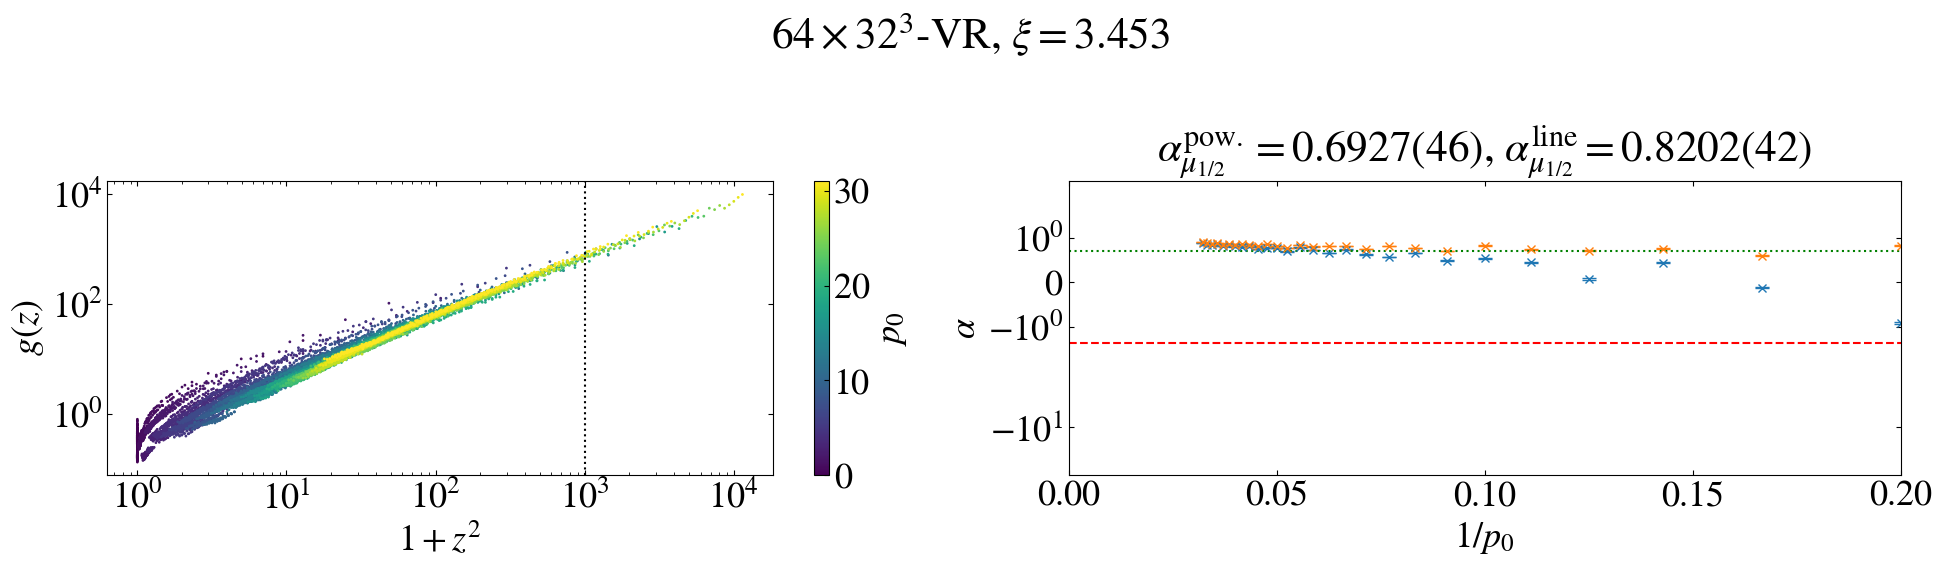

In [38]:
fig,ax = plt.subplots(1,2,figsize=(20,6))

cbar = ax[0].scatter(1+z**2,[g_.mean for g_ in g],s=1,c=qi[:,0])

ax[0].set_yscale('log')
ax[0].set_xscale('log')
plt.colorbar(cbar,label="$p_0$",ax=ax[0])
ax[0].set_xlabel("$1+z^2$")
ax[0].set_ylabel("$g(z)$")

ax[0].axvline(cut,ls=':',c='k')

ax[1].errorbar(1/np.unique(qi[:,0])[1:],[a.mean for a in alphas],[a.sdev for a in alphas],ls='',fmt='x')
ax[1].errorbar(1/np.unique(qi[:,0])[1:],[a.mean for a in line_alphas],[a.sdev for a in line_alphas],ls='',fmt='x')

ax[1].axhline(np.median(alphas).mean,ls=':',c='g')
ax[1].axhline(np.mean(alphas).mean,ls='--',c='r')
fig.suptitle(f"${Nt}\\times32^3$-{mode}, $\\xi={xi}$")
ax[1].set_xlabel("$1/p_0$")
ax[1].set_ylabel("$\\alpha$")
ax[1].set_yscale('symlog')
ax[1].set_title(f'$\\alpha_{{\mu_{{1/2}}}}^\mathrm{{pow.}}={np.median(alphas)}$, $\\alpha_{{\mu_{{1/2}}}}^\mathrm{{line}}={np.median(line_alphas)}$')
ax[1].set_xlim([0.,0.2])

In [17]:
np.median(alphas).mean

0.8777412821852517

In [ ]:
np.mean(alphas).mean

In [ ]:
prop.q